In [3]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load the full dataset
full_data = datasets.ImageFolder(r"C:\Users\SURENDHAN\Desktop\repo\DR-detection\pro\new", transform=transform)

# Split the dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [8]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load pretrained ViT model for image classification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=5)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [9]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Tracking lists for loss and accuracy
train_losses = []
train_accuracies = []
val_accuracies = []


In [12]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os

# Early stopping configuration
patience = 3  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_wts = None

# Training loop
epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect all labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Calculate precision, recall, F1-score
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_all_labels = []
    val_all_predictions = []
    
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images).logits
            val_loss_batch = criterion(val_outputs, val_labels)
            
            val_loss += val_loss_batch.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
            
            # Collect all labels and predictions for validation metrics
            val_all_labels.extend(val_labels.cpu().numpy())
            val_all_predictions.extend(val_predicted.cpu().numpy())
    
    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = 100 * val_correct / val_total
    
    # Calculate validation precision, recall, F1-score
    val_precision = precision_score(val_all_labels, val_all_predictions, average='weighted')
    val_recall = recall_score(val_all_labels, val_all_predictions, average='weighted')
    val_f1 = f1_score(val_all_labels, val_all_predictions, average='weighted')

    # Log the metrics in the desired format
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.4f}, "
          f"F1-Score: {f1:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"Val_Loss: {val_epoch_loss:.4f}, "
          f"Val_Accuracy: {val_epoch_accuracy:.4f}, "
          f"Val_F1-Score: {val_f1:.4f}, "
          f"Val_Precision: {val_precision:.4f}, "
          f"Val_Recall: {val_recall:.4f}")

    # Early stopping logic
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()  # Save best model weights
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # If validation loss doesn't improve for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
        break

# Load best model weights (if early stopping triggered)
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Loaded the best model weights.")



Epoch [1/50], Loss: 0.7726, Accuracy: 80.1054, F1-Score: 0.7989, Precision: 0.7985, Recall: 0.8011, Val_Loss: 1.0069, Val_Accuracy: 62.6316, Val_F1-Score: 0.6227, Val_Precision: 0.6352, Val_Recall: 0.6263
Epoch [2/50], Loss: 0.6600, Accuracy: 85.9025, F1-Score: 0.8587, Precision: 0.8587, Recall: 0.8590, Val_Loss: 0.9722, Val_Accuracy: 63.1579, Val_F1-Score: 0.6263, Val_Precision: 0.6299, Val_Recall: 0.6316
Epoch [3/50], Loss: 0.5507, Accuracy: 90.5138, F1-Score: 0.9046, Precision: 0.9051, Recall: 0.9051, Val_Loss: 1.0257, Val_Accuracy: 57.3684, Val_F1-Score: 0.5716, Val_Precision: 0.6164, Val_Recall: 0.5737
Epoch [4/50], Loss: 0.4755, Accuracy: 93.2806, F1-Score: 0.9328, Precision: 0.9328, Recall: 0.9328, Val_Loss: 0.9587, Val_Accuracy: 63.6842, Val_F1-Score: 0.6342, Val_Precision: 0.6435, Val_Recall: 0.6368
Epoch [5/50], Loss: 0.3871, Accuracy: 95.9157, F1-Score: 0.9591, Precision: 0.9591, Recall: 0.9592, Val_Loss: 0.9356, Val_Accuracy: 64.2105, Val_F1-Score: 0.6392, Val_Precision: 0.

In [14]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar visualization

# Assuming model, val_loader, and device are defined
model.eval()  # Set model to evaluation mode
val_accuracies = []  # To store validation accuracies over epochs
correct = 0
total = 0

# Validation loop
with torch.no_grad():  # No gradient computation
    for images, labels in tqdm(val_loader, desc="Validating"):
        # Send data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  # Handle cases without logits
        _, predicted = torch.max(logits, 1)  # Get class with highest probability
        
        # Update metrics
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Correct predictions

# Compute accuracy
val_accuracy = 100 * correct / total
val_accuracies.append(val_accuracy)  # Store for tracking
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validating: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]

Validation Accuracy: 60.53%


In [15]:
print(f"Train Losses: {train_losses}")
print(f"Train Accuracies: {train_accuracies}")
print(f"Validation Accuracies: {val_accuracies}")

Train Losses: [1.5308025603493054, 1.328778271873792, 1.1650656225780647, 1.0402105810741584, 0.7725504611929258, 0.65998485746483, 0.5507457796484232, 0.47547482574979466, 0.38708930897216004, 0.31307346653193235, 0.2720958360781272, 0.24815255030989647, 0.23199469161530337]
Train Accuracies: [34.65085638998683, 53.359683794466406, 63.63636363636363, 70.75098814229248, 80.10540184453228, 85.90250329380764, 90.51383399209486, 93.28063241106719, 95.91567852437417, 96.96969696969697, 97.36495388669302, 97.49670619235836, 97.23320158102767]
Validation Accuracies: [60.526315789473685]


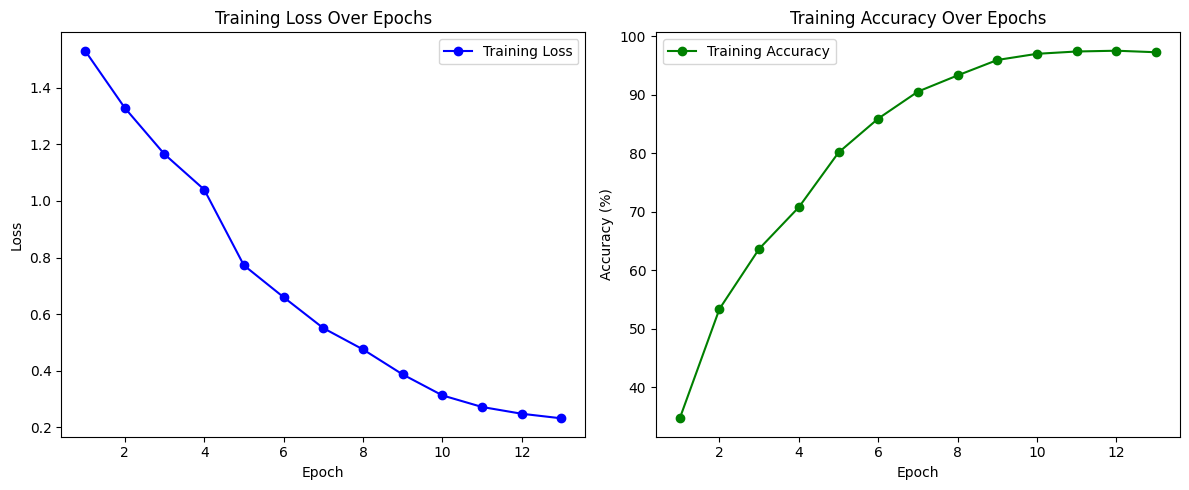

In [17]:
import matplotlib.pyplot as plt

# Set the number of actual epochs (due to early stopping)
actual_epochs = len(train_losses)

# Plotting the training statistics (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, actual_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, actual_epochs + 1), train_accuracies, label='Training Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


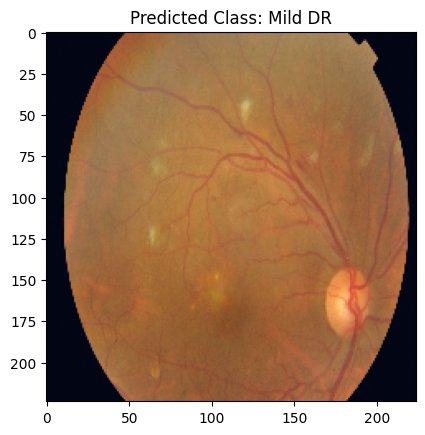

Actual Label: Mild DR


In [24]:
import random
import torch
import matplotlib.pyplot as plt

# Assuming the class names list is defined like this:
class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

# Set model to evaluation mode
model.eval()

# Get a random image from the validation set
random_idx = random.randint(0, len(val_data) - 1)
img, label = val_data[random_idx]

# Convert the image to the expected format
img = img.unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    outputs = model(img).logits
    _, predicted_class = torch.max(outputs, 1)

# Show the image and print the prediction
img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC for display
img = (img * 0.229 + 0.485)  # Denormalize (assuming ImageNet normalization)
img = img.clip(0, 1)

# Plot the image
plt.imshow(img)
plt.title(f"Predicted Class: {class_names[predicted_class.item()]}")
plt.show()

# Print the actual label
print(f"Actual Label: {class_names[label]}")
